# Lab2: Image Segmentation


<!--![ObjectDetection](https://drive.google.com/uc?id=1AeG8F2TYEMUWy6huTWBDPsU0NnLr-pyK ). -->


![Image Segmentation](https://drive.google.com/uc?id=1TABoIVgRUlUAEaFe_jzG0aOiQM5dk9qX )


The segmentation problem in computer vision refers to the division of an image into meaningful regions or segments based on features such as color, intensity, texture, or contours. The primary objective is to distinguish and identify the objects within the image by accurately delineating the boundaries between them.

From a computational standpoint, Segmentation can be interpreted as a pixel-level classification problem.

Segmentation provides fine-grained information about object boundaries and regions, while detection focuses on identifying specific objects and their locations.



**Some uses cases**


*   Autonomous Vehicles
*   Medical Imaging Analysis
*   Analysis of Satellite Images
*   Smart Agriculture
*   Industrial Inspection



Below the input and output of a classic simple segmentation problem.

In [ ]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np

img = imageio.imread("https://drive.google.com/uc?id=1oMwhUwK-tuCaAP-_2aiTyoCrLIcqkDc9")
plt.imshow(img)
plt.axis('off')
plt.show()
print(f"Input dim: {img.shape}")  # HWC

mask = imageio.imread("https://drive.google.com/uc?id=1gG8woOuLu2X4dHotXY5GKSZbHvMeOOoo")
plt.imshow(mask)
plt.axis('off')
plt.show()
print(f"Output dim: {mask.shape}")  # HWC



### What is a mask?

To highlight specific parts of a tensor containing our data, it is possible to create another tensor of the same dimensions, where each element corresponding to our target takes the value 1 (True) or 0 (False). This tensor is called a "mask" and acts as a filter, allowing the model to "turn on" or "turn off" the regions.

In Deep Learning, a mask can take on different meanings depending on its usage, but the core concept remains the same.


Key Applications of Masking
1. Ground Truth Masks in Semantic Segmentation or Object Detection.
2. Transformer Attention Mechanisms to control
3. Data Augmentation: Random Erasing/Occlusion

How mask filter ?

In [ ]:
print( np.unique(mask) )
mask//=255
print( np.unique(mask) )
mask = mask[...,None]
print( img.shape)
print( mask.shape)

In [ ]:
new_img = img*mask
plt.imshow(new_img)
plt.axis('off')
plt.show()
print(f"Output dim: {new_img.shape}")  # HWC

#Image Segmentation


What if we want to train a model to generate a mask from unseen samples ?


This is generally done with a Convolutional Neural Network that act as an image-to-image transform, mapping each pixel of $x$ to the corresponding class.

*Remind:* Given an image $x \in \mathbb{R}^{m \times n \times c}$, an image-to-image map is a function $f: \mathbb{R}^{m \times n \times c} \to \mathbb{R}^{m' \times n' \times c'}$. In our situation, $m = m'$, $n = n'$ and $c = c'$. An image-to-image map is required to do segmentation and some image processing tasks, but not for classification or object detection. \\

Image-to-image maps are usually implemented by some variant of a Fully Convolutional Neural Network (FNN) design (e.g. ResNet, Autoencoders, ...). See https://heartbeat.comet.ml/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc for details.

![Image Segmentation](https://drive.google.com/uc?id=1A2zksYq9ehq5ghNKl2sOZfkochbbgFDG )


**Semantic segmentation** separates different classes at the pixel level but does not separate different instances of the same class. The **Object detection** separates instances but provides only a crude approximation of the instance shape (the box).The task of **Instance segmentation** lays at the intersection of the two. It can be defined as the task of detecting all instances of the objects of interest in an image and classifying them; and segmenting them from the background at the pixel level.

![Image Segmentation](https://drive.google.com/uc?id=1xO189Tlv8GbE86sncajEn6LmkE3NTu6l )

###Some Segmentation datasets:

*   Pascal2:11540 images,6,929 segmentation masks and 20 categories.
     http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html:

*   ADEK20:images 25K+2K and 150 categories.
     https://groups.csail.mit.edu/vision/datasets/ADE20K/
*   Cityscapes Dataset: https://www.cityscapes-dataset.com/
*   Mapillar Vistas: https://www.mapillary.com/dataset/vistas


In [1]:
!pip install keras_cv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 27.6 MB/s eta 0:00:00


In [2]:
import random
import os
from pathlib import Path
import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

# Image Config
HEIGHT = 64
WIDTH = 64
NUM_CLASSES = 3
AUTOTUNE = tf.data.AUTOTUNE #optimize hw performance automatically
BATCH_SIZE = 32

dir="./model_weights"
if not Path(dir).exists():
  os.mkdir(dir)
  print("Folder was created")

Folder was created


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In this tutorial we are going to introduce [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).



In [3]:
#Download the datasets
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds = tfds.load( name="oxford_iiit_pet", split=["train+test[:80%]", "test[80%:]"] )

#{
#  'image': tf.Tensor,               # immagine RGB del pet
#  'label': tf.Tensor,               # classe (razza del pet)
#  'segmentation_mask': tf.Tensor,  # maschera di segmentazione (pixel-wise)
#}
#Le maschere (segmentation_mask) sono incluse automaticamente nel dataset da tfds
print(orig_val_ds.element_spec)
#orig_train_ds = contiene il training + 80% del test
#Questo tipo di split è utile se vuoi fare una nuova divisione del dataset, ad esempio per addestrare un modello con più dati o valutare su un subset specifico.
#Calcola il numero di elementi in ciascun dataset
tf.data.experimental
num_train_elements = tf.data.experimental.cardinality(orig_train_ds).numpy()
num_val_elements = tf.data.experimental.cardinality(orig_val_ds).numpy()

print("Training set length:", num_train_elements)
print("Test set length:", num_val_elements)


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
{'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}
Training set length: 6615
Test set length: 734


In [9]:
#data preprocessing
def rescale_images_and_correct_masks( inputs):
  return {
    "images": tf.cast(inputs["image"], dtype=tf.float32) / 255.0, #normalization
    "segmentation_masks": inputs["segmentation_mask"] - 1, #put all values as 0-based.
  }
#now the label of the ground truth pixels are 0 for pet, 1 for borders, 2 for background


#utility function, Serve a convertire il dizionario {images, segmentation_masks} in una tupla,come richiesto da Keras nei modelli supervisati.
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


train_ds = orig_train_ds.map( rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE )
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
#map applica una funzione a ogni elemento del dataset, uno per uno (o in parallelo),senza usare un ciclo for esplicito.
#Un thread è una unità di esecuzione all'interno di un processo,AUTOTUNE:TensorFlow sceglie automaticamente il numero ottimale di thread


resize_fn = keras_cv.layers.Resizing( HEIGHT, WIDTH ) #ridimensiona le immagini e le maschere a dimensioni fisse

resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE) #Dataset finale pronto per il training
)

resized_train_ds = (
    train_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE) # carica i batch in anticipo, per migliorare le prestazioni durante il training
)

Image Shape: (9, None, None, 3)
Segmentation Mask Shape: (9, None, None, 1)


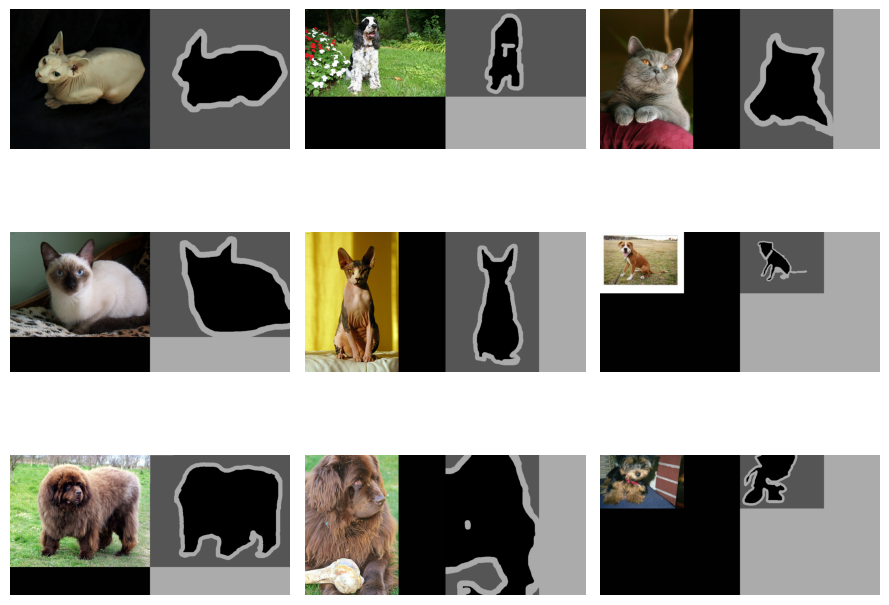

In [12]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(9)#4  #ragged handles variable image shapes

images, segmentation_masks = next(iter(plot_train_ds.take(1)))

print( f"Image Shape: {images.shape}"  )
print( f"Segmentation Mask Shape: {segmentation_masks.shape}"  )

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0,1),#-1
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=3,
    rows=3,#2
    cols=3,#2
)

In [11]:
#Create a callback

# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(resized_val_ds))

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:  #Viene eseguito alla fine di ogni epoca.

            self.model.save_weights(save_path)

            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis] #add a new dimension at the end of pred_masks.
            # ... is a placeholder for dimensions

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(f"Predicted Mask: {epoch:03d}", )

            plt.show()
            plt.close()

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    restore_best_weights=True,
    start_from_epoch=0,
    patience=3
)


callbacks = [DisplayCallback(5),early_stopping]




In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## UNet

Maybe the most known network architecture used for segmentation is the UNet.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

The basics are:

  - On downsampling (MaxPooling2D layer), the dimensions in Height and Width is divided by 2 while Filters Channels are dubled

  - On upsampling (ConvTranspose2D layer), Height and Width are doubled and Filter channels halved. The formula of output is:
         output_size=(input_size−1)×stride+kernel_size−2×padding
  So we'll have:
  
  new_height=(28−1)×2+2=56

  new_width=(28−1)×2+2=56

  - 2 layers of Conv2D (3x3, padding=same) for each block

  - The bottleneck captures global context information

  - Skipping connections (copy,crop and concatenate) help decoder to generate a map.
  
  - Final layer is typically a 1×1 convolution that maps the feature vector to the desired number of classes. (1 for us)
  

This factors and others leads to strong training stability


**NOTE**

Conv2D prende in input una image è crea una matrice di spessore= n. filtri applicati (1-->64)


**padding='same'**:Obiettivo: Mantenere le dimensioni spaziali (altezza e larghezza) dell'output uguali a quelle dell'input.
Aggiunge zeri attorno ai bordi dell'input in modo che il filtro possa essere applicato a ogni elemento dell'input, inclusi i bordi.

**padding='valid'**:Obiettivo: Applicare il filtro solo alle posizioni dell'input dove il filtro si adatta completamente, senza aggiungere padding.
Non aggiunge alcun padding; di conseguenza, le dimensioni spaziali dell'output sono ridotte rispetto all'input.

**stride:** Stride is a parameter that dictates the movement of the kernel, or filter, across the input data, such as an image. When performing a convolution operation, the stride determines how many units the filter shifts at each step. This shift can be horizontal, vertical, or both, depending on the stride's configuration.
For example, a stride of 1 moves the filter one pixel at a time, while a stride of 2 moves it two pixels. A larger stride will produce a smaller output dimension, effectively downsampling the image.

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def unet(img_size=(256, 256, 1), num_classes=1):
    inputs = Input(shape=img_size + (3,))

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)
    conv3, pool3 = down_block(pool2, 256)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    #Up Blocks
    conv5 = up_block(conv4, conv3, 256)
    conv6 = up_block(conv5, conv2, 128)
    conv7 = up_block(conv6, conv1, 64)

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv7)

    model = Model(inputs=inputs, outputs=outputs, name="unet")
    return model


# Build model
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)
#save_path=f"./model_weights/weights_img{HEIGHT}x{WIDTH}.weights.h5"
save_path=f"/content/drive/MyDrive/IAALAB_2324/Lezione5/weights_img{HEIGHT}x{WIDTH}.weights.h5"
model.summary()
if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 256) │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 16, 16,    │          0 │ conv2d_45[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 16, 16,    │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 768)              │            │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │  1,769,728 │ concatenate_7[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_46[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 32, 32,    │          0 │ conv2d_47[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,784,579 (29.70 MB)

 Trainable params: 7,784,579 (29.70 MB)

 Non-trainable params: 0 (0.00 B)

TensorFlow is using CPU


In [13]:
# Training Config
EPOCHS = 30
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

try:
    model.load_weights(save_path)
    print("The model was loaded")
except Exception as e:
    print(f"No weights loaded:\n{e}")


# Train the model, doing validation at the end of each epoch.
history = model.fit(
    resized_train_ds,
    epochs=EPOCHS,
    validation_data=resized_val_ds,
    callbacks=callbacks,
)

No weights loaded:
[Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/IAALAB_2324/Lezione5/weights_img64x64.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Epoch 1/30
131/207 ━━━━━━━━━━━━━━━━━━━━ 16:48 13s/step - accuracy: 0.5837 - loss: 0.9812

KeyboardInterrupt: 

In [ ]:
model.save_weights(save_path)

In [ ]:
# np.save("val_accuracy", hist.history['val_accuracy'])

In [ ]:
model.load_weights(save_path)

pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=-1)[..., None]

keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=3,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=4,
)

#original source code at https://keras.io/examples/vision/oxford_pets_image_segmentation/#prediction-with-trained-model

In [ ]:
# Check overfit
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()


The Intersection over Union (IoU) is a metrics used in segmentation problems.

 It is defined as the ratio between the intersection area between the predicted mask and the ground truth mask, over the union between the two masks.

![](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)


*   IoU scores close to 1.0 indicate a high level of accuracy. The predicted and ground truth areas overlap perfectly, meaning the area of overlap equals the area of union.

when the predicted and groud truth areas overlap eachother perfectly. In other words, if the area of overlap is the same of the area of union.

*   Conversely, IoU scores close to 0 suggest poor accuracy, indicating little to no overlap between the predicted and ground truth regions.




In the case of segmentation, the intersection over union is computed considering each individual pixel in the predicted segmentation mask and the ground truth mask.

$$
IoU_{pixel} = \frac{\sum_{i=1}^{N}(P_i \cap G_i)}{\sum_{i=1}^{N}(P_i \cup G_i)}
$$


Where:


*   *Pi* is the predicted segmentation mask at pixel i,
*   *Gi* is the ground truth mask at pixel i,
*   *∩* denotes the intersection operator,
*   *∪* denotes the union operator, and
*   *N* is the total number of pixels in the image.

**Recap of accuracy formula:**
$$
Accuracy = \frac{Number\ of\ right\ predictions}{Total\ number\ of\ predictions}
$$


In [ ]:
# import keras.ops as K
import keras.backend as K

def iou_coeff(y_true, y_pred):
    print("y_true shape", y_true.shape)
    print("y_pred shape", y_pred.shape)
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def evaluate_model(model, validation_dataset, fun):
    y_pred = model.predict(validation_dataset)
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_pred = y_pred.astype('float32')
    y_true = y_true.astype('float32')
    evaluation_result = fun(y_true, y_pred)
    return evaluation_result

iou = evaluate_model(model, resized_val_ds, iou_coeff)
print("Pixel wise IoU:", iou.numpy())

Try to experiment by yourself at home.

Some suggested readings:

*  [Panoptic Segmentation](https://openaccess.thecvf.com/content_CVPR_2019/papers/Kirillov_Panoptic_Segmentation_CVPR_2019_paper.pdf)

*    [Panoptic FeaturePyramidNetwork](https://arxiv.org/pdf/1901.02446.pdf)


###Intersection over union

# SAM: Segment anything model

from Meta AI lab research



In [ ]:
!pip install keras transformers

In [ ]:
import imageio.v2 as imageio
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO


import imageio.v2 as imageio


def print_images(imgs):
  fig, axes = plt.subplots(1, len(imgs), figsize=(4 * len(imgs), 4))
  axes = [axes] if len(imgs) == 1 else axes #make ax iterable: ax != ax[0]
  for i, img in enumerate(imgs):
      axes[i].imshow(img)
      axes[i].set_title(f"shape: {img.shape}")
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()



urls = [
    "https://drive.google.com/uc?id=1vWgkE4_TUuBJhlsZv7JdURRCM_WoYNRl",
    "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png" #is RGBA
]

imgs = [imageio.imread(url)[..., :3] for url in urls]

print_images(imgs)


Generate random points to prompt the model

In [ ]:
def sample_points(img_size, num_points=250, distance_factor=0.5):
    height, width = img_size

    # The distance from top-left corner of the image decrease with num of points
    topl_distance_pct = max(0.05, 1 / np.sqrt(num_points))
    #side is the distance from ..
    side = min(width, height) * distance_factor

    #Compute randomly the point on the top left corner
    x0 = np.random.uniform( width*topl_distance_pct, width - side)
    y0 = np.random.uniform( height*topl_distance_pct, height - side)

    # Generate uniformely distributed points
    points = []


    for _ in range(num_points):
        x = np.random.uniform(x0, x0 + side)
        y = np.random.uniform(y0, y0 + side)
        points.append([x, y])

    return points

num_points=4
# we generate random points
pnts=[
    sample_points(imgs[0].shape[:2],num_points ),
    sample_points(imgs[1].shape[:2],num_points )
]

for p in pnts:
  print(p)

def add_redpoints_toimg_fun(im, pts):
  itmp = im.copy()
  min_len = min(im.shape[:2])
  print(im.shape)
  print(len(pts))

  for pt in pts:
    x, y = int(pt[0]), int(pt[1])
    blue=(0, 0, 255) #rgb
    rds = min_len//50
    cv2.circle(itmp, (x, y), color=blue, radius=rds, thickness=-1)
  return itmp


modified_ims = [ add_redpoints_toimg_fun(im,pts) for im, pts in zip(imgs, pnts) ]

#show output
print_images(modified_ims)

In [ ]:
from transformers import TFSamModel, SamProcessor

# Load the model and processor
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessing_fun = processor
postprocessing_fun = processor.image_processor.post_process_masks

In [ ]:
#SAM inference

#imgs : the list of images
#pnts : the list of points
inputs = preprocessing_fun( images=imgs,  input_points=pnts, return_tensors="tf",multimask_output=False)

outputs = model(inputs)

preds = outputs.pred_masks
scores = outputs.iou_scores

masks = postprocessing_fun(
    masks=preds,
    original_sizes=inputs["original_sizes"],
    reshaped_input_sizes=inputs["reshaped_input_sizes"],
    return_tensors="tf"
)


In [ ]:
for m in masks:
  print(m.shape)

reshaped_masks = [ m.numpy().squeeze().transpose(1,2,0).astype(np.float32) for m in masks ]

print( reshaped_masks[0].shape )
print( reshaped_masks[1].shape )

#reshaped = np.array()..astype(np.float32) #from CHW to HWC
print_images(reshaped_masks)

In [ ]:
def generate_grid(img_size, num_points):
    h,w = img_size
    num_points_x = int(np.sqrt(num_points * (w / h)))  # Colonne
    num_points_y = num_points // num_points_x  # Righe

    # Calcola la distanza tra i punti
    distance_x = w / num_points_x
    distance_y = h / num_points_y

    # Crea la griglia
    return [[x * distance_x, y * distance_y] for x in range(num_points_x) for y in range(num_points_y)]

def generate_grid(img_size, rows, cols):
    h, w = img_size

    # Calcola la spaziatura
    step_x = w / cols
    step_y = h / rows

    # Genera la griglia
    grid = []
    for row in range(rows):
        for col in range(cols):
            x = col * step_x + step_x / 2  # Centra il punto nella cella
            y = row * step_y + step_y / 2  # Centra il punto nella cella
            grid.append([x, y])

    return grid

rows_points=3
cols_points=3

pnts=[
    generate_grid(imgs[0].shape[:2], rows_points, cols_points),
    generate_grid(imgs[1].shape[:2], rows_points, cols_points)
]

modified_ims = [ add_redpoints_toimg_fun(im,pts) for im, pts in zip(imgs, pnts) ]
#show output
print_images(modified_ims)



Repeat the experiment

In [ ]:
#SAM inference

#imgs : the list of images
#pnts : the list of points
inputs = preprocessing_fun( images=imgs,  input_points=pnts, return_tensors="tf",multimask_output=False)

outputs = model(inputs)

preds = outputs.pred_masks
scores = outputs.iou_scores

masks = postprocessing_fun(
    masks=preds,
    original_sizes=inputs["original_sizes"],
    reshaped_input_sizes=inputs["reshaped_input_sizes"],
    return_tensors="tf"
)

for m in masks:
  print(m.shape)

reshaped_masks = [ m.numpy().squeeze().transpose(1,2,0).astype(np.float32) for m in masks ]

print( reshaped_masks[0].shape )
print( reshaped_masks[1].shape )

#reshaped = np.array()..astype(np.float32) #from CHW to HWC
print_images(reshaped_masks)